# ESC-50 audio classification

This notebook is an example of audio classification using convolutional neural network.
<br>
The data used is [ESC-50](https://github.com/karoldvl/ESC-50), which consists of 50 classes of environmental audio dataset.<br>
One data is in .wav format with 5 seconds each, total of 2,000 files.

In [3]:
import os
import random
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn import model_selection
from sklearn import preprocessing
import IPython.display as ipd

## Preparation

In [4]:
# define directories
base_dir = "C:/Users/uekaz/Downloads/ESC-50-master"
esc_dir = os.path.join(base_dir, "ESC-50-master")
meta_file = os.path.join(esc_dir, "meta/esc50.csv")
audio_dir = os.path.join(esc_dir, "audio/")

In [5]:
# load metadata
meta_data = pd.read_csv(meta_file)
meta_data

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A
...,...,...,...,...,...,...,...
1995,5-263831-B-6.wav,5,6,hen,False,263831,B
1996,5-263902-A-36.wav,5,36,vacuum_cleaner,False,263902,A
1997,5-51149-A-25.wav,5,25,footsteps,False,51149,A
1998,5-61635-A-8.wav,5,8,sheep,False,61635,A


In [6]:
# get data size
data_size = meta_data.shape
print(data_size)

(2000, 7)


In [7]:
# arrange target label and its name
class_dict = {}
for i in range(data_size[0]):
    if meta_data.loc[i,"target"] not in class_dict.keys():
        class_dict[meta_data.loc[i,"target"]] = meta_data.loc[i,"category"]
class_pd = pd.DataFrame(list(class_dict.items()), columns=["labels","classes"])
class_pd

,labels,classes
0,0,dog
1,14,chirping_birds
2,36,vacuum_cleaner
3,19,thunderstorm
4,30,door_wood_knock
5,34,can_opening
6,9,crow
7,22,clapping
8,48,fireworks
9,41,chainsaw


## Load dataset

In [8]:
# load a wave data
def load_wave_data(audio_dir, file_name):
    file_path = os.path.join(audio_dir, file_name)
    x, fs = librosa.load(file_path, sr=44100)
    return x,fs

In [9]:
# change wave data to mel-stft
def calculate_melsp(x, n_fft=1024, hop_length=128):
    stft = np.abs(librosa.stft(x, n_fft=n_fft, hop_length=hop_length))**2
    log_stft = librosa.power_to_db(stft)
    melsp = librosa.feature.melspectrogram(S=log_stft,n_mels=128)
    return melsp

In [10]:
# display wave in plots
def show_wave(x):
    plt.plot(x)
    plt.show()

In [11]:
# display wave in heatmap
def show_melsp(melsp, fs):
    librosa.display.specshow(melsp, sr=fs)
    plt.colorbar()
    plt.show()

wave size:(220500,)
melsp size:(128, 1723)
samping rate:44100


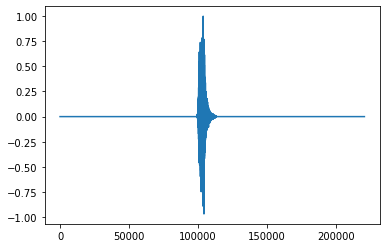

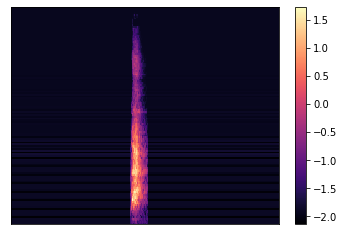

In [12]:
# example data
x, fs = load_wave_data(audio_dir, meta_data.loc[0,"filename"])
melsp = calculate_melsp(x)
print("wave size:{0}\nmelsp size:{1}\nsamping rate:{2}".format(x.shape, melsp.shape, fs))
show_wave(x)
show_melsp(melsp, fs)

In [13]:
ipd.Audio(x, rate=fs)

## Augment audio data

In [14]:
# data augmentation: add white noise
def add_white_noise(x, rate=0.002):
    return x + rate*np.random.randn(len(x))

wave size:(220500,)
melsp size:(128, 1723)
samping rate:44100


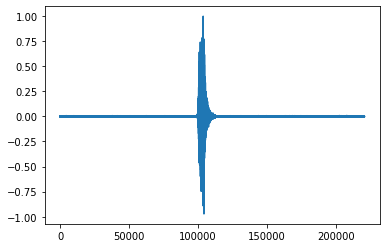

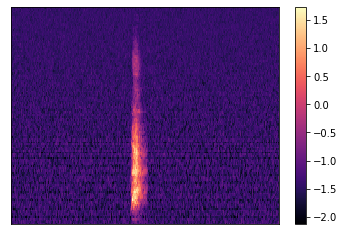

In [15]:
x_wn = add_white_noise(x)
melsp = calculate_melsp(x_wn)
print("wave size:{0}\nmelsp size:{1}\nsamping rate:{2}".format(x_wn.shape, melsp.shape, fs))
show_wave(x_wn)
show_melsp(melsp, fs)

In [16]:
ipd.Audio(x_wn, rate=fs)

In [17]:
# data augmentation: shift sound in timeframe
def shift_sound(x, rate=2):
    return np.roll(x, int(len(x)//rate))

wave size:(220500,)
melsp size:(128, 1723)
samping rate:44100


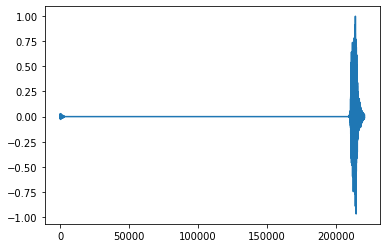

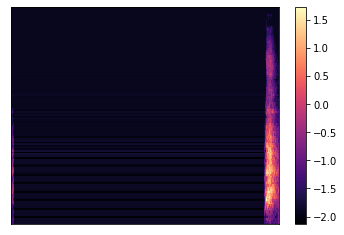

In [18]:
x_ss = shift_sound(x)
melsp = calculate_melsp(x_ss)
print("wave size:{0}\nmelsp size:{1}\nsamping rate:{2}".format(x_ss.shape, melsp.shape, fs))
show_wave(x_ss)
show_melsp(melsp, fs)

In [19]:
ipd.Audio(x_ss, rate=fs)

In [20]:
# data augmentation: stretch sound
def stretch_sound(x, rate=1.1):
    input_length = len(x)
    x = librosa.effects.time_stretch(x, rate)
    if len(x)>input_length:
        return x[:input_length]
    else:
        return np.pad(x, (0, max(0, input_length - len(x))), "constant")

wave size:(220500,)
melsp size:(128, 1723)
samping rate:44100


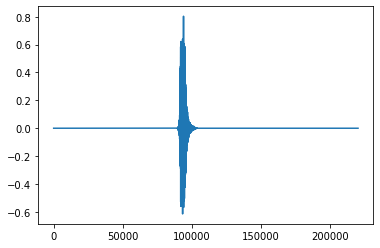

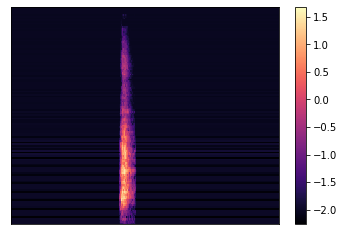

In [21]:
x_st = stretch_sound(x)
melsp = calculate_melsp(x_st)
print("wave size:{0}\nmelsp size:{1}\nsamping rate:{2}".format(x_st.shape, melsp.shape, fs))
show_wave(x_st)
show_melsp(melsp, fs)

In [22]:
ipd.Audio(x_st, rate=fs)

## Split training dataset and test dataset

In [23]:
# get training dataset and target dataset
x = list(meta_data.loc[:,"filename"])
y = list(meta_data.loc[:, "target"])

x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, test_size=0.25, stratify=y)
print("x train:{0}\ny train:{1}\nx test:{2}\ny test:{3}".format(len(x_train),
                                                                len(y_train), 
                                                                len(x_test), 
                                                                len(y_test)))

x train:1500
y train:1500
x test:500
y test:500


In [24]:
a = np.zeros(50)
for c in y_test:
    a[c] += 1
print(a)

[10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.]


## Transform wav data to mel-stft array

Transform wav data files to mel-stft array, and save them as npz, separately with test, training and augmented training datasets.

In [25]:
freq = 128
time = 1723

In [26]:
from tqdm import tqdm_notebook as tqdm
# save wave data in npz, with augmentation
def save_np_data(filename, x, y, aug=None, rates=None):
    np_data = np.zeros(freq*time*len(x)).reshape(len(x), freq, time)
    np_targets = np.zeros(len(y))
    for i in tqdm(range(len(y))):
        _x, fs = load_wave_data(audio_dir, x[i])
        if aug is not None:
            _x = aug(x=_x, rate=rates[i])
        _x = calculate_melsp(_x)
        np_data[i] = _x
        np_targets[i] = y[i]
    np.savez(filename, x=np_data, y=np_targets)  

In [27]:
# save test dataset
if not os.path.exists("esc_melsp_test.npz"):
    save_np_data("esc_melsp_test.npz", x_test,  y_test)

In [28]:
# save raw training dataset
if not os.path.exists("esc_melsp_train_raw.npz"):
    save_np_data("esc_melsp_train_raw.npz", x_train,  y_train)

In [29]:
# save training dataset with white noise
if not os.path.exists("esc_melsp_train_wn.npz"):
    rates = np.random.randint(1,50,len(x_train))/10000
    save_np_data("esc_melsp_train_wn.npz", x_train,  y_train, aug=add_white_noise, rates=rates)

In [30]:
# save training dataset with sound shift
if not os.path.exists("esc_melsp_train_ss.npz"):
    rates = np.random.choice(np.arange(2,6),len(y_train))
    save_np_data("esc_melsp_train_ss.npz", x_train,  y_train, aug=shift_sound, rates=rates)

In [31]:
# save training dataset with stretch
if not os.path.exists("esc_melsp_train_st.npz"):
    rates = np.random.choice(np.arange(80,120),len(y_train))/100
    save_np_data("esc_melsp_train_st.npz", x_train,  y_train, aug=stretch_sound, rates=rates)

In [32]:
# save training dataset with combination of white noise and shift or stretch
if not os.path.exists("esc_melsp_train_com.npz"):
    np_data = np.zeros(freq*time*len(x_train)).reshape(len(x_train), freq, time)
    np_targets = np.zeros(len(y_train))
    for i in tqdm(range(len(y_train))):
        x, fs = load_wave_data(audio_dir, x_train[i])
        x = add_white_noise(x=x, rate=np.random.randint(1,50)/1000)
        if np.random.choice((True,False)):
            x = shift_sound(x=x, rate=np.random.choice(np.arange(2,6)))
        else:
            x = stretch_sound(x=x, rate=np.random.choice(np.arange(80,120))/100)
        x = calculate_melsp(x)
        np_data[i] = x
        np_targets[i] = y_train[i]
    np.savez("esc_melsp_train_com.npz", x=np_data, y=np_targets)

## Audio classification with deep learning 

## Preparation for deep learning

In [33]:
import keras
from keras.models import Model
from keras.layers import Input, Dense, Dropout, Activation
from keras.layers import Conv2D, GlobalAveragePooling2D
from keras.layers import BatchNormalization, Add
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model

Using TensorFlow backend.


In [50]:
# dataset files
train_files = ["esc_melsp_train_raw.npz", 
               "esc_melsp_train_ss.npz",
               "esc_melsp_train_st.npz", 
               "esc_melsp_train_wn.npz",
               "esc_melsp_train_com.npz"]
test_file = "esc_melsp_test.npz"

In [51]:
train_num = 1500
test_num = 500

In [52]:
# define dataset placeholders
x_train = np.zeros(freq*time*train_num*len(train_files)).reshape(train_num*len(train_files), freq, time)
y_train = np.zeros(train_num*len(train_files))

In [53]:
# load dataset
for i in tqdm(range(len(train_files))):
    data = np.load(train_files[i])
    x_train[i*train_num:(i+1)*train_num] = data["x"]
    y_train[i*train_num:(i+1)*train_num] = data["y"]

In [69]:
# load test dataset
test_data = np.load(test_file)
x_test = test_data["x"]
y_test = test_data["y"]

In [70]:
# redefine target data into one hot vector
#classes = 50
y_train = keras.utils.to_categorical(y_train, classes)
y_test = keras.utils.to_categorical(y_test, classes)

In [71]:
# reshape training dataset
x_train = x_train.reshape(train_num*5, freq, time, 1)
x_test = x_test.reshape(test_num, freq, time, 1)

In [72]:
#classes = 50
#y_test = keras.utils.to_categorical(y_test, classes)
#x_test = x_test.reshape(test_num, freq, time, 1)

In [73]:
print("x train:{0}\ny train:{1}\nx test:{2}\ny test:{3}".format(x_train.shape,
                                                                y_train.shape, 
                                                                x_test.shape, 
                                                                y_test.shape))

x train:(7500, 128, 1723, 1)
y train:(7500, 50)
x test:(500, 128, 1723, 1)
y test:(500, 50)


## Define convolutional neural network

In [74]:
def cba(inputs, filters, kernel_size, strides):
    x = Conv2D(filters, kernel_size=kernel_size, strides=strides, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

In [75]:
# define CNN
inputs = Input(shape=(x_train.shape[1:]))

x_1 = cba(inputs, filters=32, kernel_size=(1,8), strides=(1,2))
x_1 = cba(x_1, filters=32, kernel_size=(8,1), strides=(2,1))
x_1 = cba(x_1, filters=64, kernel_size=(1,8), strides=(1,2))
x_1 = cba(x_1, filters=64, kernel_size=(8,1), strides=(2,1))

x_2 = cba(inputs, filters=32, kernel_size=(1,16), strides=(1,2))
x_2 = cba(x_2, filters=32, kernel_size=(16,1), strides=(2,1))
x_2 = cba(x_2, filters=64, kernel_size=(1,16), strides=(1,2))
x_2 = cba(x_2, filters=64, kernel_size=(16,1), strides=(2,1))

x_3 = cba(inputs, filters=32, kernel_size=(1,32), strides=(1,2))
x_3 = cba(x_3, filters=32, kernel_size=(32,1), strides=(2,1))
x_3 = cba(x_3, filters=64, kernel_size=(1,32), strides=(1,2))
x_3 = cba(x_3, filters=64, kernel_size=(32,1), strides=(2,1))

x_4 = cba(inputs, filters=32, kernel_size=(1,64), strides=(1,2))
x_4 = cba(x_4, filters=32, kernel_size=(64,1), strides=(2,1))
x_4 = cba(x_4, filters=64, kernel_size=(1,64), strides=(1,2))
x_4 = cba(x_4, filters=64, kernel_size=(64,1), strides=(2,1))

x = Add()([x_1, x_2, x_3, x_4])

x = cba(x, filters=128, kernel_size=(1,16), strides=(1,2))
x = cba(x, filters=128, kernel_size=(16,1), strides=(2,1))

x = GlobalAveragePooling2D()(x)
x = Dense(classes)(x)
x = Activation("softmax")(x)

model = Model(inputs, x)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 128, 1723, 1) 0                                            
__________________________________________________________________________________________________
conv2d_37 (Conv2D)              (None, 128, 862, 32) 288         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_41 (Conv2D)              (None, 128, 862, 32) 544         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_45 (Conv2D)              (None, 128, 862, 32) 1056        input_3[0][0]                    
____________________________________________________________________________________________

## Optimization and callbacks

In [76]:
# initiate Adam optimizer
opt = keras.optimizers.Adam(lr=0.00001, decay=1e-6, amsgrad=True)

# Let's train the model using Adam with amsgrad
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [77]:
# directory for model checkpoints
model_dir = "./models"
if not os.path.exists(model_dir):
    os.mkdir(model_dir)

# early stopping and model checkpoint# early  
es_cb = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')
chkpt = os.path.join(model_dir, 'esc50_.{epoch:02d}_{val_loss:.4f}_{val_acc:.4f}.hdf5')
cp_cb = ModelCheckpoint(filepath = chkpt, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

## Train CNN model with between class dataset

In [78]:
# between class data generator
class MixupGenerator():
    def __init__(self, x_train, y_train, batch_size=16, alpha=0.2, shuffle=True):
        self.x_train = x_train
        self.y_train = y_train
        self.batch_size = batch_size
        self.alpha = alpha
        self.shuffle = shuffle
        self.sample_num = len(x_train)

    def __call__(self):
        while True:
            indexes = self.__get_exploration_order()
            itr_num = int(len(indexes) // (self.batch_size * 2))

            for i in range(itr_num):
                batch_ids = indexes[i * self.batch_size * 2:(i + 1) * self.batch_size * 2]
                x, y = self.__data_generation(batch_ids)

                yield x, y

    def __get_exploration_order(self):
        indexes = np.arange(self.sample_num)

        if self.shuffle:
            np.random.shuffle(indexes)

        return indexes

    def __data_generation(self, batch_ids):
        _, h, w, c = self.x_train.shape
        _, class_num = self.y_train.shape
        x1 = self.x_train[batch_ids[:self.batch_size]]
        x2 = self.x_train[batch_ids[self.batch_size:]]
        y1 = self.y_train[batch_ids[:self.batch_size]]
        y2 = self.y_train[batch_ids[self.batch_size:]]
        l = np.random.beta(self.alpha, self.alpha, self.batch_size)
        x_l = l.reshape(self.batch_size, 1, 1, 1)
        y_l = l.reshape(self.batch_size, 1)

        x = x1 * x_l + x2 * (1 - x_l)
        y = y1 * y_l + y2 * (1 - y_l)

        return x, y

In [ ]:
# train model
batch_size = 16
epochs = 1000

training_generator = MixupGenerator(x_train, y_train)()
model.fit_generator(generator=training_generator,
                    steps_per_epoch=x_train.shape[0] // batch_size,
                    validation_data=(x_test, y_test),
                    epochs=epochs, 
                    verbose=1,
                    shuffle=True,
                    callbacks=[es_cb, cp_cb])

Epoch 1/1000
127/468 [=======>......................] - ETA: 6:36:29 - loss: 3.8337 - accuracy: 0.0000e+0 - ETA: 5:51:59 - loss: 3.9503 - accuracy: 0.0000e+0 - ETA: 5:36:16 - loss: 3.9622 - accuracy: 0.0000e+0 - ETA: 5:26:55 - loss: 3.9743 - accuracy: 0.0000e+0 - ETA: 5:23:29 - loss: 3.9403 - accuracy: 0.0125    - ETA: 5:24:52 - loss: 3.9687 - accuracy: 0.010 - ETA: 5:24:52 - loss: 3.9648 - accuracy: 0.008 - ETA: 5:21:28 - loss: 3.9680 - accuracy: 0.007 - ETA: 5:18:33 - loss: 3.9715 - accuracy: 0.006 - ETA: 5:18:47 - loss: 3.9778 - accuracy: 0.006 - ETA: 5:16:42 - loss: 3.9700 - accuracy: 0.005 - ETA: 5:14:18 - loss: 3.9748 - accuracy: 0.005 - ETA: 5:12:17 - loss: 3.9800 - accuracy: 0.004 - ETA: 5:10:26 - loss: 3.9744 - accuracy: 0.004 - ETA: 5:08:22 - loss: 3.9706 - accuracy: 0.004 - ETA: 5:06:42 - loss: 3.9814 - accuracy: 0.003 - ETA: 5:05:33 - loss: 3.9873 - accuracy: 0.003 - ETA: 5:04:34 - loss: 3.9859 - accuracy: 0.003 - ETA: 5:03:34 - loss: 3.9873 - accuracy: 0.003 - ETA: 5:02:30

## Evaluate model

In [1]:
model = load_model("./models/esc50_.105_0.8096_0.8200.hdf5")

NameError: name 'load_model' is not defined

In [2]:
evaluation = model.evaluate(x_test, y_test)
print(evaluation)

NameError: name 'model' is not defined